# Produce geometrical ZR and energy map

### Imports

In [84]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import analysis_utils    as ats

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.io   . dst_io        import load_dsts
from invisible_cities.io   . dst_io        import load_dst
from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)
#save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

%matplotlib inline

### Read data

In [5]:
list_dir = ['base_config/', 'refl_walls/', 'no_refl_sipms/', 'wider_ring/']

reco_r1       = [[] for j in range(len(list_dir))]
reco_r2       = [[] for j in range(len(list_dir))]
reco_z1       = [[] for j in range(len(list_dir))]
reco_z2       = [[] for j in range(len(list_dir))]
events        = [[] for j in range(len(list_dir))]
sns_response1 = [[] for j in range(len(list_dir))]
sns_response2 = [[] for j in range(len(list_dir))]
charges1      = [[] for j in range(len(list_dir))]
charges2      = [[] for j in range(len(list_dir))]

eventsPath  = '/data5/users/carmenromo/comparison_ring_confs/2_data_pos_charge_no_compton/'
for j, conf in enumerate(list_dir):
    for filename in os.listdir(eventsPath+conf):
        if filename.endswith('.npz'):
            my_file   = eventsPath+conf+filename
            print(filename)
            d = np.load(my_file)
        
            for i in d['a_reco_r1']:
                reco_r1[j].append(i)
            for i in d['a_reco_r2']:
                reco_r2[j].append(i)
            for i in d['a_reco_z1']:
                reco_z1[j].append(i)
            for i in d['a_reco_z2']:
                reco_z2[j].append(i)
                
            for i in d['a_sns_response1']:
                sns_response1[j].append(i)
            for i in d['a_sns_response2']:
                sns_response2[j].append(i)
            print(len(d['a_events']))
            for i in d['a_events']:
                events[j] .append(i)
            
for j in range(len(list_dir)):
    reco_r1      [j] = np.array(reco_r1      [j])
    reco_r2      [j] = np.array(reco_r2      [j])
    reco_z1      [j] = np.array(reco_z1      [j])
    reco_z2      [j] = np.array(reco_z2      [j])
    events       [j] = np.array(events       [j])
    sns_response1[j] = np.array(sns_response1[j])
    sns_response2[j] = np.array(sns_response2[j])
    charges1     [j] = np.array([sum(n) for n in sns_response1[j]])
    charges2     [j] = np.array([sum(n) for n in sns_response2[j]])

full_ring_irad165mm_depth3cm_reco_pos_charge_220_20_6_0.npz
3881
full_ring_irad165mm_depth3cm_reco_pos_charge_100_20_6_0.npz
3828
full_ring_irad165mm_depth3cm_reco_pos_charge_300_20_6_0.npz
3864
full_ring_irad165mm_depth3cm_reco_pos_charge_460_20_6_0.npz
3943
full_ring_irad165mm_depth3cm_reco_pos_charge_420_20_6_0.npz
3857
full_ring_irad165mm_depth3cm_reco_pos_charge_80_20_6_0.npz
4043
full_ring_irad165mm_depth3cm_reco_pos_charge_280_20_6_0.npz
4017
full_ring_irad165mm_depth3cm_reco_pos_charge_140_20_6_0.npz
3959
full_ring_irad165mm_depth3cm_reco_pos_charge_180_20_6_0.npz
3885
full_ring_irad165mm_depth3cm_reco_pos_charge_380_20_6_0.npz
3896
full_ring_irad165mm_depth3cm_reco_pos_charge_120_20_6_0.npz
3934
full_ring_irad165mm_depth3cm_reco_pos_charge_440_20_6_0.npz
3985
full_ring_irad165mm_depth3cm_reco_pos_charge_60_20_6_0.npz
3919
full_ring_irad165mm_depth3cm_reco_pos_charge_400_20_6_0.npz
3887
full_ring_irad165mm_depth3cm_reco_pos_charge_20_20_6_0.npz
3861
full_ring_irad165mm_depth3cm

In [19]:
reco_z   = [[] for j in range(len(list_dir))]
reco_r   = [[] for j in range(len(list_dir))]
charges  = [[] for j in range(len(list_dir))]

for i in range(len(list_dir)):
    reco_z  [i] = np.concatenate((reco_z1  [i], reco_z2  [i]), axis=0)
    reco_r  [i] = np.concatenate((reco_r1  [i], reco_r2  [i]), axis=0)
    charges [i] = np.concatenate((charges1 [i], charges2 [i]), axis=0)

### Notebook configuration

In [31]:
identifiers   = ['irad165mm_depth3cm', 'irad165mm_d3cm_refl_walls', 'irad165mm_d3cm_no_refl_sipms', 'irad165mm_d4cm']
list_ranges_r = [(165.0, 195.0), (165.0, 195.0), (165.0, 195.0), (165.0, 205.0)]
list_bins_r   = [(6, 12, 15), (6, 12, 15), (6, 12, 15), (8, 16, 20)]

In [ ]:
a_non_corrected_charge1 = np.array(non_corrected_charge1)
a_non_corrected_charge2 = np.array(non_corrected_charge2)
a_corrected_charge1_0   = np.array(corrected_charge1_0  )
a_corrected_charge2_0   = np.array(corrected_charge2_0  )
a_corrected_charge1_1   = np.array(corrected_charge1_1  )
a_corrected_charge2_1   = np.array(corrected_charge2_1  )
a_corrected_charge1_2   = np.array(corrected_charge1_2  )
a_corrected_charge2_2   = np.array(corrected_charge2_2  )

np.savez(evt_file, a_non_corrected_charge1=non_corrected_charge1, a_non_corrected_charge2=non_corrected_charge2, a_corrected_charge1_0=corrected_charge1_0, a_corrected_charge2_0=corrected_charge2_0, a_corrected_charge1_1=corrected_charge1_1, a_corrected_charge2_1=corrected_charge2_1, a_corrected_charge1_2=corrected_charge1_2, a_corrected_charge2_2=corrected_charge2_2)  


In [85]:
num_conf   = 0
identifier = identifiers[num_conf]

overwrite = True

Zrange = -70.0, 70.0
Znbins = [28, 56, 70]
Rrange = list_ranges_r[num_conf]
Rnbins = list_bins_r[num_conf]

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

plots_output_folder = '/data5/users/carmenromo/comparison_ring_confs/'

Z = reco_z [num_conf][~np.isnan(reco_r[num_conf])]
R = reco_r [num_conf][~np.isnan(reco_r[num_conf])]
E = charges[num_conf][~np.isnan(reco_r[num_conf])]

### Initialization

In [86]:
Zbins    = {n: np.linspace(*Zrange,   n     + 1) for n in Znbins}
Zcenters = {n: shift_to_bin_centers(bins)        for n, bins in Zbins.items()}
Zpitch   = {n: np.diff(bins)[0]                  for n, bins in Zbins.items()}
Rbins    = {n: np.linspace(*Rrange,   n     + 1) for n in Rnbins}
Rcenters = {n: shift_to_bin_centers(bins)        for n, bins in Rbins.items()}
Rpitch   = {n: np.diff(bins)[0]                  for n, bins in Rbins.items()}

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Event distribution

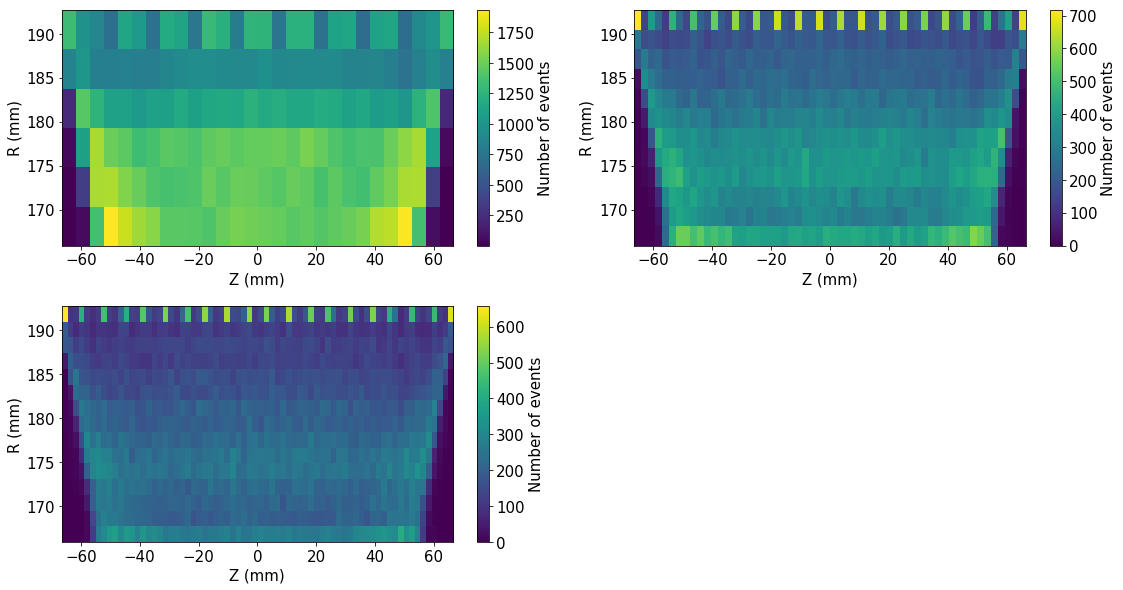

In [87]:
Nevt = {}
i    = 1
for nZ, nR in zip(Znbins, Rnbins):
    zbins  = Zbins [nZ]
    rbins  = Rbins [nR]
    zpitch = Zpitch[nZ]
    rpitch = Rpitch[nR]
    
    plt.subplot(3, 2, i)
    nevt, *_ = plt.hist2d(Z, R, (nZ, nR))
    plt.colorbar().set_label("Number of events")
    labels("Z (mm)", "R (mm)", f"Event distribution for {zpitch:.1f} and {rpitch:.1f} mm pitch")

    Nevt[(nZ, nR)]  = nevt
    i       += 1

plt.tight_layout()

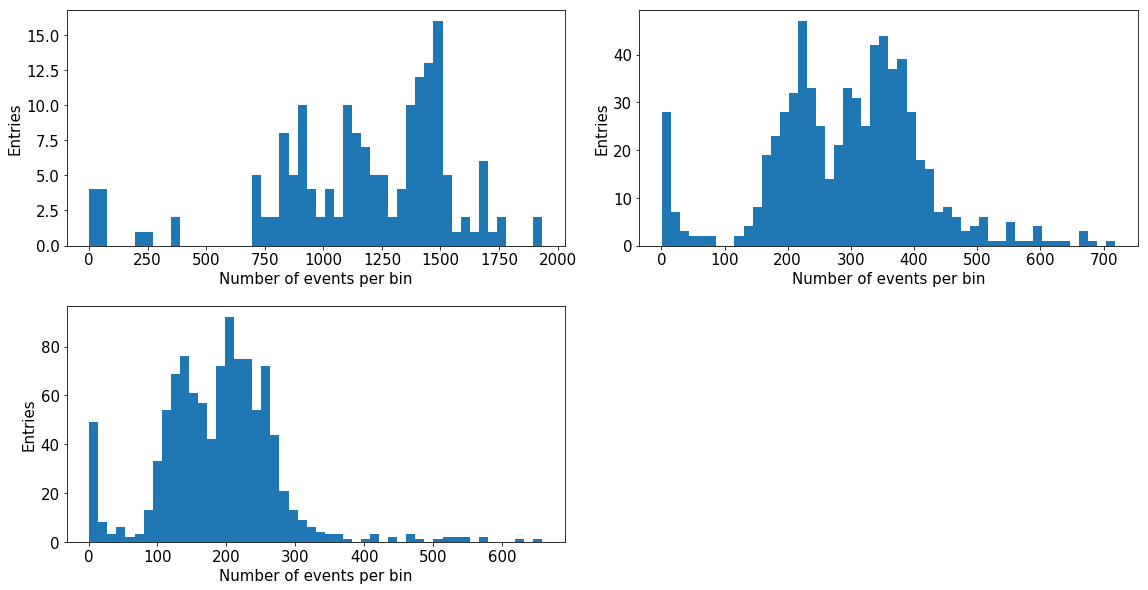

In [88]:
i = 1
for iZ, iR in zip(Znbins, Rnbins):
    nevt    = Nevt[(iZ, iR)]
    zpitch  = Zpitch[iZ]
    rpitch  = Rpitch[iR]
    nevt_max = int(np.max(nevt))

    plt.subplot(3, 2, i)
    plt.hist(nevt.flatten(), 50, (1, nevt_max + 1))
    labels("Number of events per bin", "Entries", f"# events per bin for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()

### Compute geometry map

In [89]:
Eave  = {}
Eaveu = {}

E_mean  = {}
Eu_mean = {}
E_std   = {}
Eu_std  = {}

E_min  = {}
E_max  = {}
Eu_min = {}
Eu_max = {}

for nZ, nR in zip(Znbins, Rnbins):
    
    *_, Eave_, Eaveu_ = fitf.profileXY(Z, R, E, nZ, nR, Zrange, Rrange)
    Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)   
    Eok               = Eave_ > 0.
   
    Eave   [(nZ, nR)] = Eave_
    Eaveu  [(nZ, nR)] = Eaveu_
    
    E_mean [(nZ, nR)] = np.mean(Eave_ [Eok])
    E_std  [(nZ, nR)] = np.std (Eave_ [Eok])
    
    Eu_mean[(nZ, nR)] = np.mean(Eaveu_[Eok])
    Eu_std [(nZ, nR)] = np.std (Eaveu_[Eok])
    
    E_min  [(nZ, nR)] =      E_mean[(nZ, nR)] - 3.0 *  E_std[(nZ, nR)]
    E_max  [(nZ, nR)] =      E_mean[(nZ, nR)] + 2.0 *  E_std[(nZ, nR)]
    
    Eu_min [(nZ, nR)] = max(Eu_mean[(nZ, nR)] - 1.5 * Eu_std[(nZ, nR)], 1e-3)
    Eu_max [(nZ, nR)] =     Eu_mean[(nZ, nR)] + 2.0 * Eu_std[(nZ, nR)]

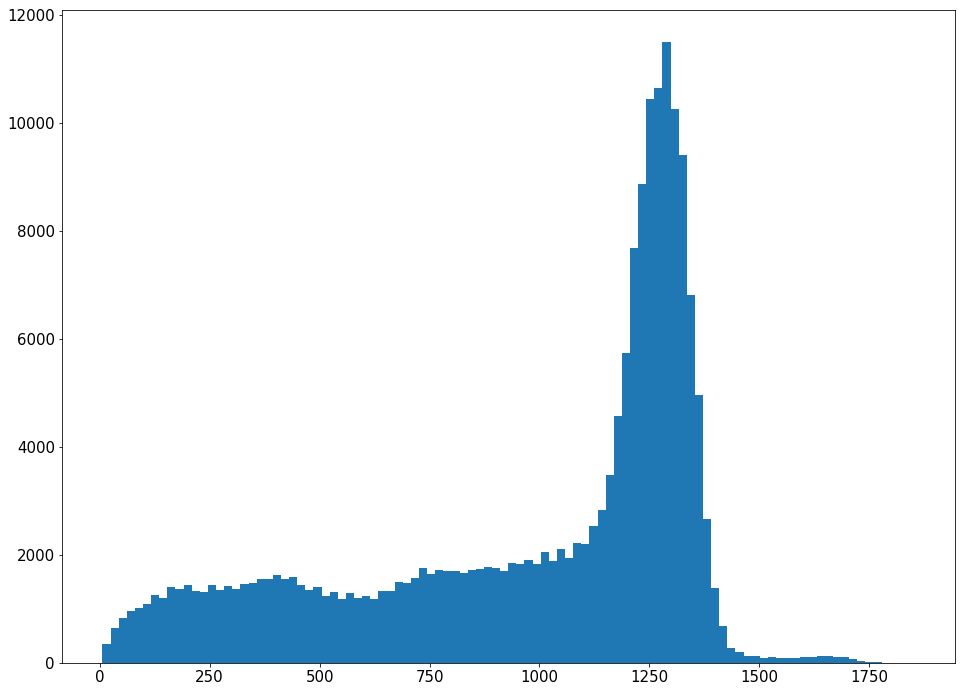

In [90]:
h = hist(E, 100, new_figure=False)

### Charge map display

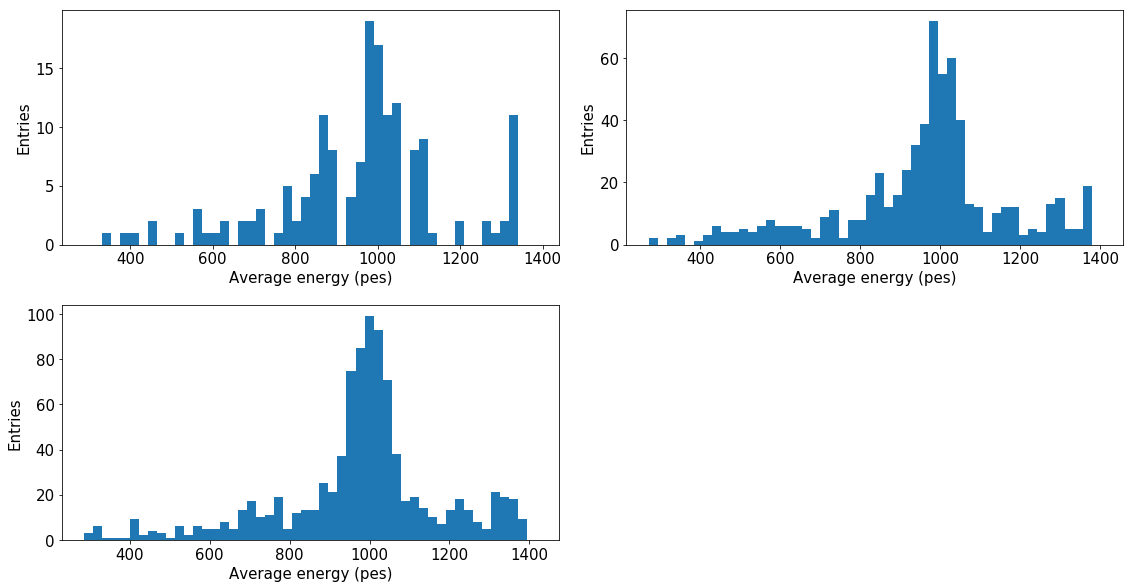

In [78]:
i = 1
for nZ, nR in zip(Znbins, Rnbins):
    zpitch = Zpitch[nZ]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    plt.hist(Eave[(nZ, nR)].flatten(), 50, (E_min[(nZ, nR)], E_max[(nZ, nR)]))
    labels("Average energy (pes)", "Entries", f"Average energy for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()

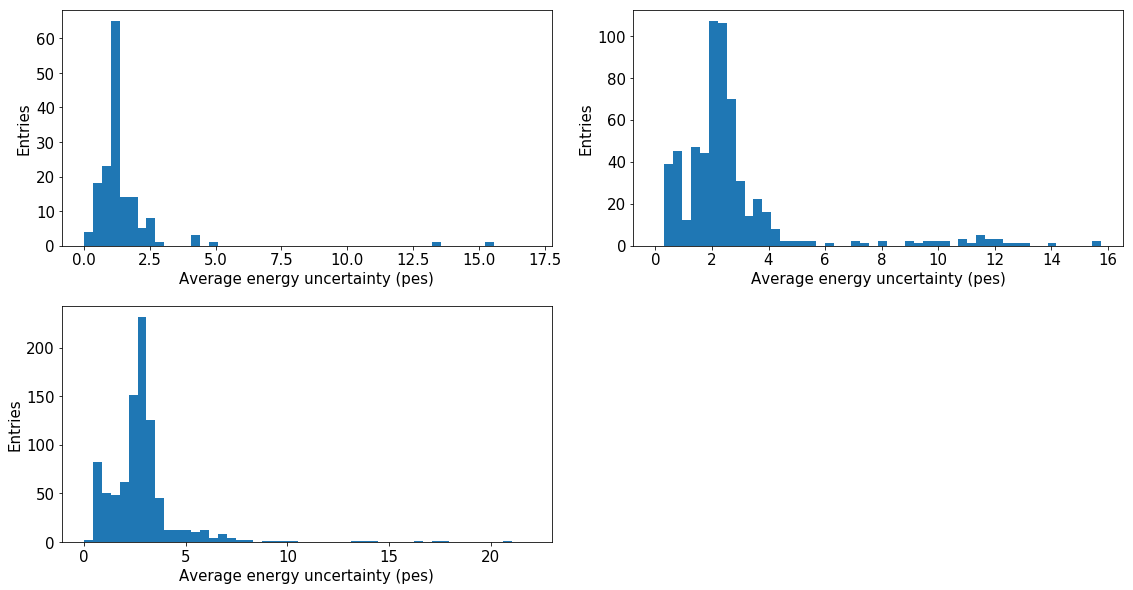

In [91]:
i = 1
for nZ, nR in zip(Znbins, Rnbins):
    zpitch = Zpitch[nZ]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    plt.hist(Eaveu[(nZ, nR)].flatten(), 50, (Eu_min[(nZ, nR)], Eu_max[(nZ, nR)]))
    labels("Average energy uncertainty (pes)", "Entries", f"Average energy uncertainty for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()

Average energy for 5.0 and 5.0 mm pitch
Average energy for 2.5 and 2.5 mm pitch
Average energy for 2.0 and 2.0 mm pitch


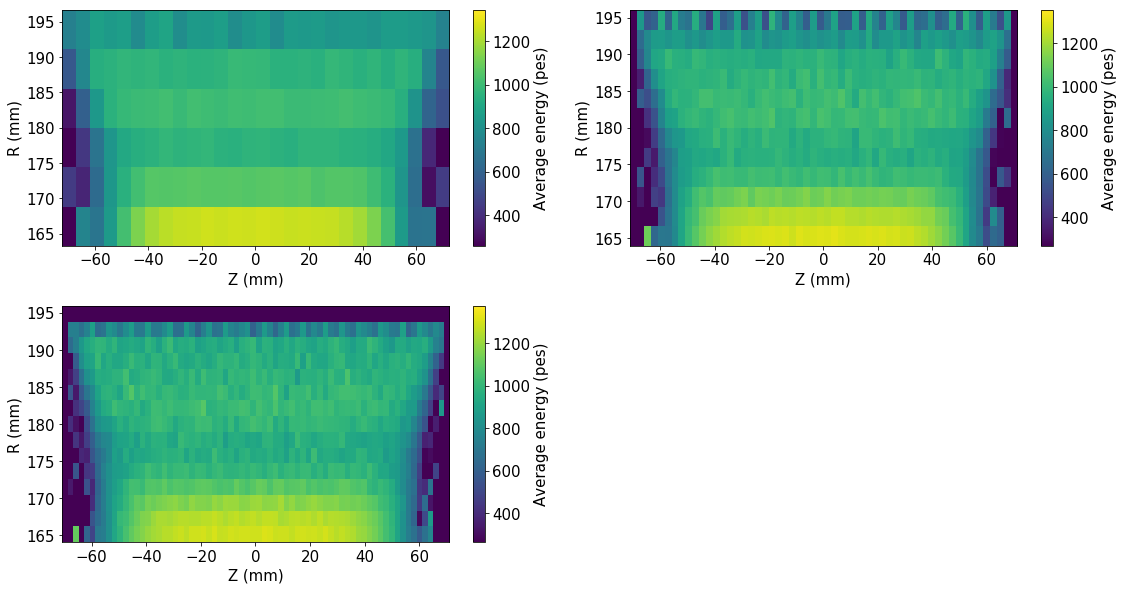

In [92]:
i = 1
for nZ, nR in zip(Znbins, Rnbins):
    zpitch = Zpitch[nZ]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Zcenters[nZ], Rcenters[nR], Eave[(nZ, nR)],
                            vmin = E_min[(nZ, nR)],
                            vmax = E_max[(nZ, nR)],
                            cmap = default_cmap,
                            new_figure = False)
    print(f"Average energy for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    cb.set_label("Average energy (pes)")
    labels("Z (mm)", "R (mm)", f"Average energy for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1
    
plt.tight_layout()

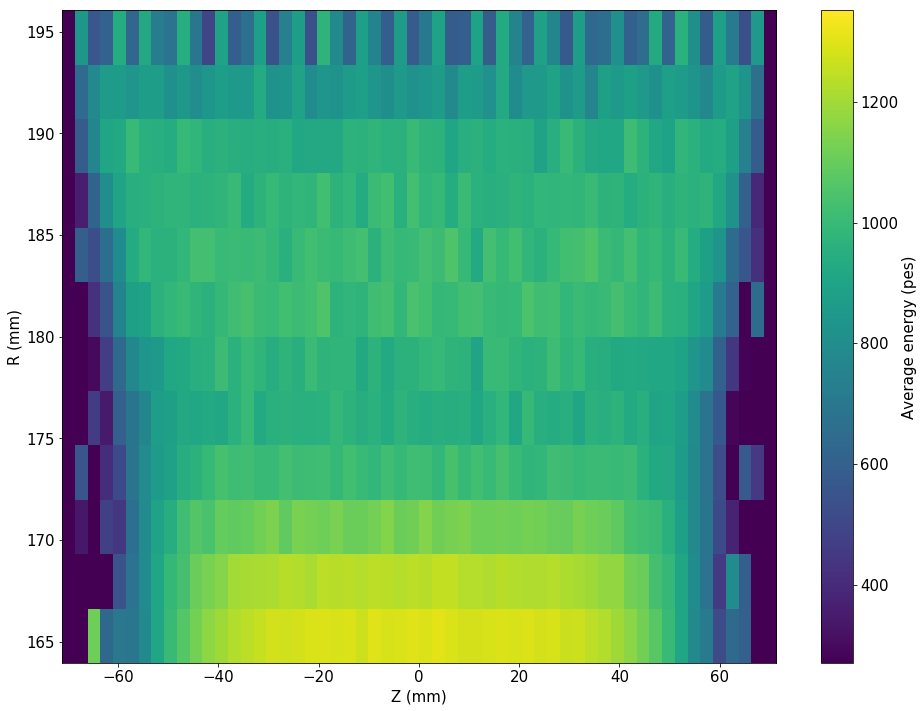

In [93]:
z = Znbins[1]
r = list_bins_r[num_conf][1]

zpitch = Zpitch[z]
rpitch = Rpitch[r]
*_, cb = display_matrix(Zcenters[z], Rcenters[r], Eave[(z, r)],
                        vmin = E_min[(z, r)],
                        vmax = E_max[(z, r)],
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("Z (mm)", "R (mm)", f"Average energy for {zpitch:.1f} and {rpitch:.1f} mm pitch")

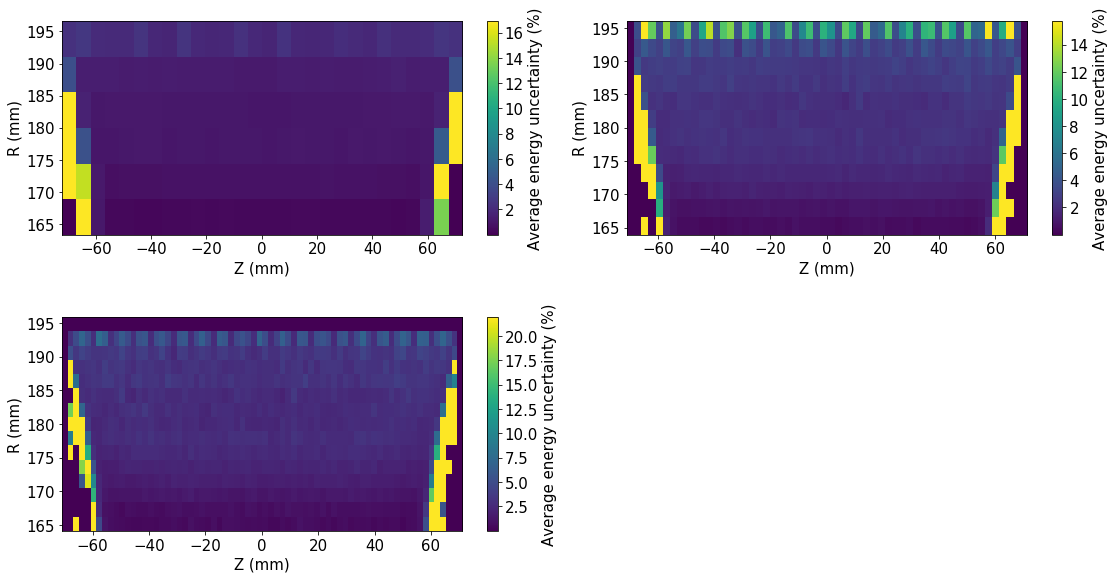

In [94]:
i = 1
for nZ, nR in zip(Znbins, Rnbins):
    zpitch = Zpitch[nZ]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Zcenters[nZ], Rcenters[nR], Eaveu[(nZ, nR)],
                            vmin = Eu_min[(nZ, nR)],
                            vmax = Eu_max[(nZ, nR)],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average energy uncertainty (%)")
    labels("Z (mm)", "R (mm)", f"Average energy unc. for {zpitch:.1f} and {rpitch:.1f} mm pitch")
    i += 1

plt.tight_layout()

## Produce HDF5 output

### Table for different pitches

In [95]:
correction_filename  = f"corrections_full_ring_{identifier}_no_compton.h5"
correction_filenames = {}
n = 0
for pZ, pR in zip(Zpitch.items(), Rpitch.items()):
    correction_filenames[n] = correction_filename.replace(".h5", "_GEO{pZ:.1f}mm_{pR:.1f}mm.h5")
    n += 1

with tb.open_file(correction_filename, "w") as output_file:
    for nZ, nR in zip(Znbins, Rnbins):
        zpitch = np.around(Zpitch[nZ], decimals=1)
        rpitch = Rpitch[nR]
        group      =  "ZRcorrections"
        table_name = f"GeometryE_{zpitch:.1f}mm_{rpitch:.1f}mm"
        if (group      in output_file.root                 and
            table_name in getattr(output_file.root, group)):
            output_file.remove_node(getattr(output_file.root, group), table_name)
        write = ats.zr_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
        write(Zcenters[nZ], Rcenters[nR], Eave[(nZ, nR)], Eaveu[(nZ, nR)] * Eave[(nZ, nR)] / 100, Nevt[(nZ, nR)])

        table = getattr(getattr(output_file.root, group), table_name)
        table.attrs.z_bins  = nZ
        table.attrs.r_bins  = nR
        table.attrs.z_pitch = zpitch
        table.attrs.r_pitch = rpitch